In [1]:
import pandas as pd

In [2]:
# Cell line structure data frame, columns are cell lines, rows are gene mutations ordered by descending frequency
mutation_df = pd.read_csv("../dataset/Cancer/binary_mutations.csv")
# Response data frame, columns have cell line name, drug name and auc score
response_df = pd.read_csv("../dataset/Cancer/cell_drug_responses.csv")
# Drug structure data frame, columns are drug name, rows are morgan footprint entries
morgan_footprints_df = pd.read_csv("../dataset/Cancer/morgan_footprints.csv")

In [12]:
mutation_df.head()

,U2OS,MCF7,GAMG,LN229,SF295,HEC108,HEC151,HEC251,HEC265,HEC59,...,OC316,TDOTT,EWS502,TM87,MON,SW900,TEN,S117,NCIH157DM,ISTMES2
0,1,0,1,1,1,0,0,1,1,0,...,1,0,0,0,1,1,0,1,1,0
1,1,1,1,1,0,1,1,1,1,1,...,1,0,0,0,0,1,1,1,1,1
2,1,1,1,1,0,1,0,1,1,1,...,0,0,0,0,1,1,0,1,1,0
3,0,1,1,1,1,1,1,1,0,1,...,1,0,1,0,0,1,0,0,1,0
4,0,0,1,1,1,1,0,1,0,1,...,1,1,1,0,0,1,1,1,1,1


In [14]:
response_df.head()

,ccl_name,cpd_name,normalized_auc
0,U2OS,zebularine,0.382479
1,U2OS,maraviroc,0.437133
2,U2OS,DL-TBOA,0.434657
3,U2OS,triptolide,0.135200
4,U2OS,Bax channel blocker,0.332011


In [15]:
morgan_footprints_df.head()

,zebularine,maraviroc,DL-TBOA,triptolide,Bax channel blocker,CCT036477,sirolimus,OSW-1,brefeldin A,itraconazole,...,tucatinib,vindesine,vinblastine,UNC0631,pardoprunox,rubitecan,vinflunine,XL-647,PI3K-IN-2,verubulin
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
ccls = response_df["ccl_name"].unique().tolist()
cpds = response_df["cpd_name"].unique().tolist()
ccl_ref = mutation_df.columns.tolist()
cpd_ref = morgan_footprints_df.columns.tolist()

In [4]:
is_contained = set(ccls).issubset(set(ccl_ref))
print(is_contained) 

True


In [5]:
import numpy as np

In [16]:
# transfer data frame to matrix
mutation_ref = mutation_df.to_numpy()
# row represents cells and column represents mutations
mutation_ref = mutation_ref.T
# get cell line reference
cell_line_ref = mutation_df.columns.tolist()

In [17]:
# transfer data frame to matrix
morgan_footprints_ref = morgan_footprints_df.to_numpy()
# row represents drugs and column represents structures
morgan_footprints_ref = morgan_footprints_ref.T
# get drug reference
drug_ref = morgan_footprints_df.columns.tolist()

In [23]:
from umap import UMAP
import matplotlib.pyplot as plt

/tmp/ipykernel_27190/4136302014.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], cmap="Spectral", s=1, alpha=0.6)


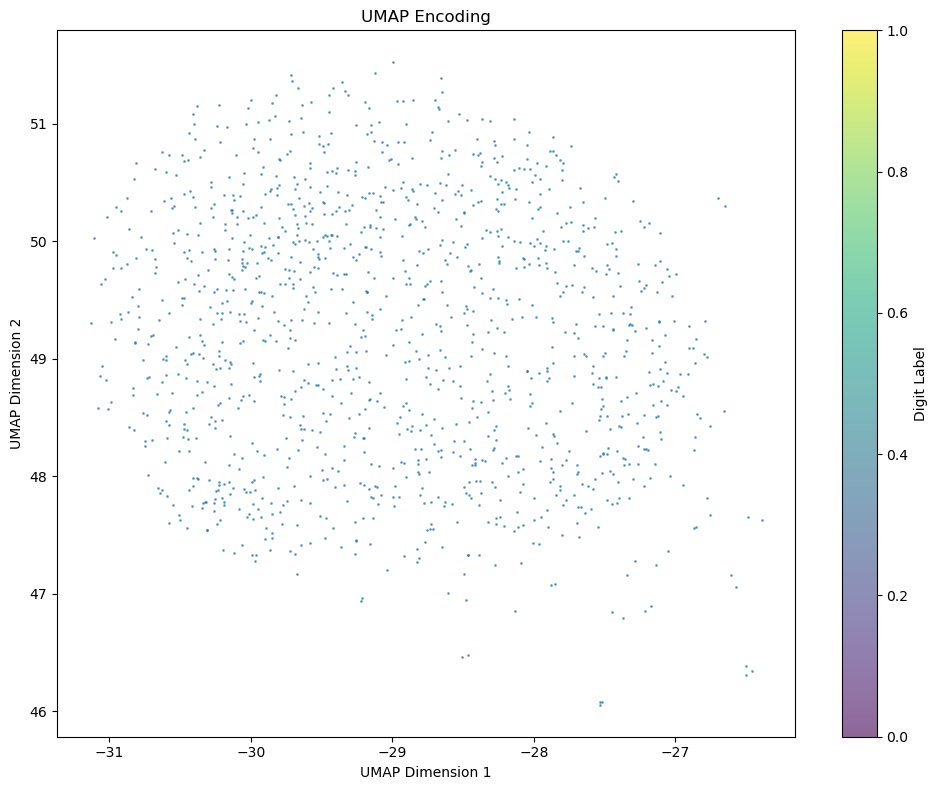

In [12]:
umap = UMAP()
# Fit and transform the data
X_train_umap = umap.fit_transform(mutation_ref)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], cmap="Spectral", s=1, alpha=0.6)
plt.colorbar(scatter, label="Digit Label")
plt.title("UMAP Encoding")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
# Show the plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_27190/3260410161.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], cmap="Spectral", s=1, alpha=0.6)


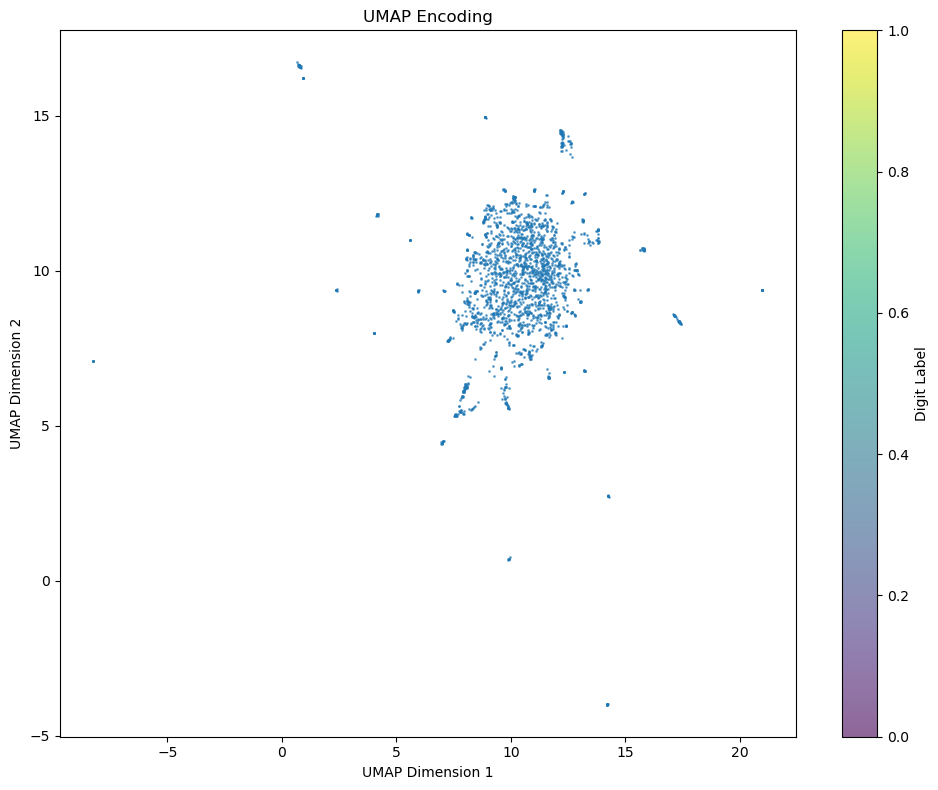

In [13]:
umap = UMAP()
# Fit and transform the data
X_train_umap = umap.fit_transform(morgan_footprints_ref)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], cmap="Spectral", s=1, alpha=0.6)
plt.colorbar(scatter, label="Digit Label")
plt.title("UMAP Encoding")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
# Show the plot
plt.tight_layout()
plt.show()

In [18]:
from scipy.sparse import csr_matrix, vstack, hstack

In [19]:
df1 = response_df.sample(n=50000)  # ccl_name, cpd_name, auc
df2 = mutation_df.head(3008)  # Mutation matrix (ccl_name as columns)
df3 = morgan_footprints_df  # Morgan fingerprint matrix (cpd_name as columns)

# Function to extract mutation & fingerprint vectors in batches
def extract_sparse_vectors(df, column_names):
    data_list = []
    for col in column_names:
        if col in df.columns:
            data_list.append(csr_matrix(df[col].values.reshape(1, -1)).astype(np.uint8))
        else:
            # Handle missing columns by appending zero vectors
            data_list.append(csr_matrix(np.zeros((df.shape[0], 1), dtype=np.uint8)))
    return vstack(data_list, format="csr")

# 1. Extract mutation vectors (batch processing)
mutation_vectors = extract_sparse_vectors(df2, df1['ccl_name'])

# 2. Extract Morgan fingerprint vectors (batch processing)
fingerprint_vectors = extract_sparse_vectors(df3, df1['cpd_name'])

# 3. Extract AUC labels
labels = csr_matrix(df1['normalized_auc'].values.reshape(-1, 1))

# 4. Concatenate sparse matrices
dataset_sparse = hstack([mutation_vectors, fingerprint_vectors, labels], format="csr")

# (Optional) Convert to DataFrame for analysis
mutation_cols = [f'mutation_{i}' for i in range(mutation_vectors.shape[1])]
fingerprint_cols = [f'fingerprint_{i}' for i in range(fingerprint_vectors.shape[1])]
column_names = mutation_cols + fingerprint_cols + ['normalized_auc']

final_df = pd.DataFrame(dataset_sparse.toarray(), columns=column_names)

In [28]:
len(column_names)

5057

In [27]:
final_df.head()

,mutation_0,mutation_1,mutation_2,mutation_3,mutation_4,mutation_5,mutation_6,mutation_7,mutation_8,mutation_9,...,fingerprint_2039,fingerprint_2040,fingerprint_2041,fingerprint_2042,fingerprint_2043,fingerprint_2044,fingerprint_2045,fingerprint_2046,fingerprint_2047,normalized_auc
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.909039
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181819
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.143134
3,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.970230
4,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.252412


In [36]:
data = final_df.to_numpy()
X = data[:,:-1]
y = data[:, -1:].reshape(-1)

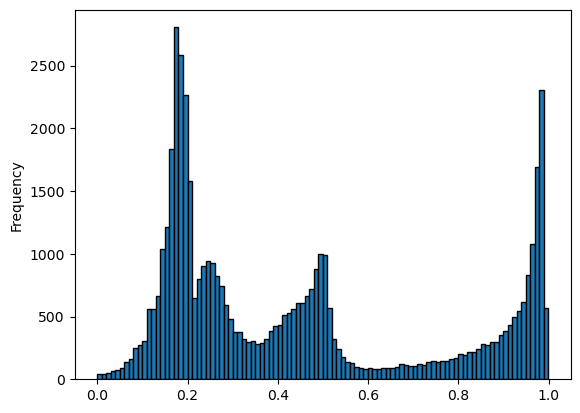

In [24]:
df1["normalized_auc"].plot(kind='hist', bins=100, edgecolor='black')
plt.show()

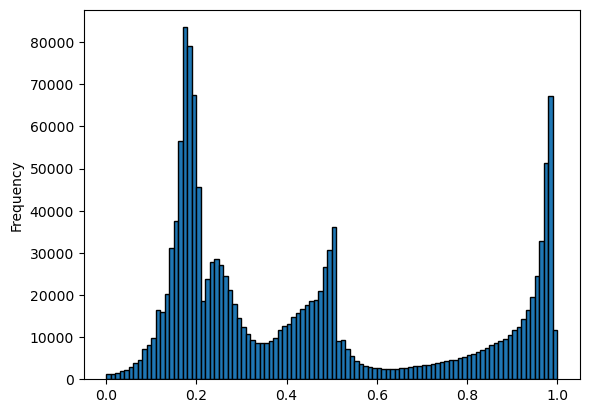

In [25]:
response_df["normalized_auc"].plot(kind='hist', bins=100, edgecolor='black')
plt.show()

In [37]:
X.shape

(50000, 5056)

In [38]:
y.shape

(50000,)

/home/leo/miniforge3/envs/hdp/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


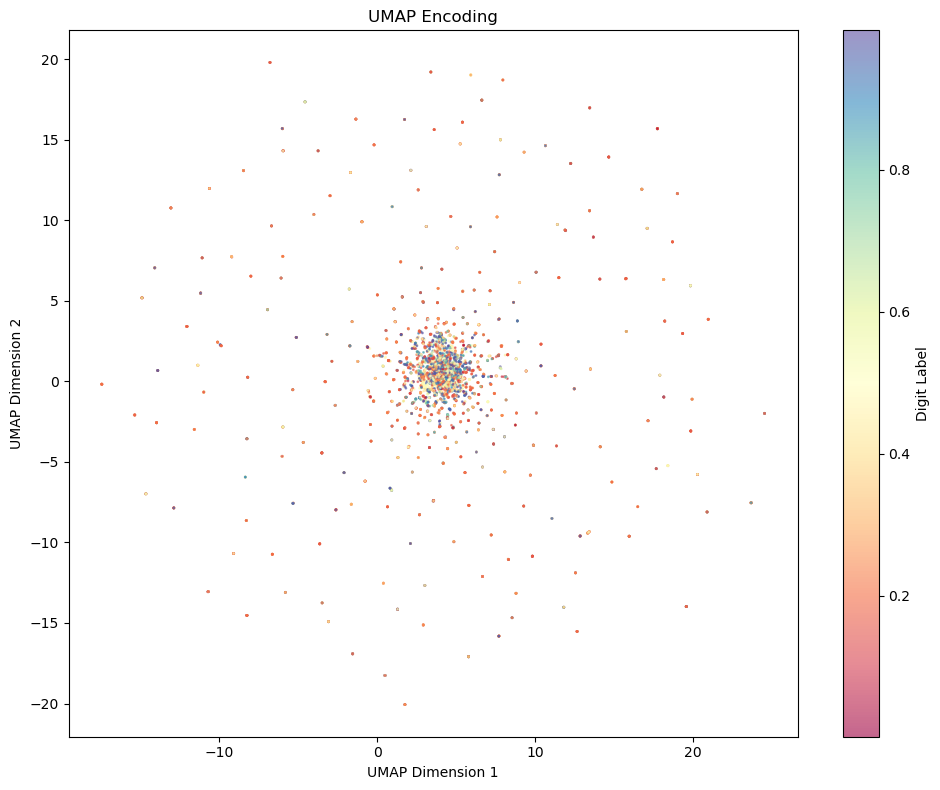

In [21]:
umap = UMAP()
# Fit and transform the data
X_train_umap = umap.fit_transform(X[:5000, :])

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y[:5000], cmap="Spectral", s=1, alpha=0.6)
plt.colorbar(scatter, label="Digit Label")
plt.title("UMAP Encoding")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
# Show the plot
plt.tight_layout()
plt.show()

In [22]:
response_df.to_csv("../dataset/Cancer/cell_drug_responses.csv", index=True)

In [ ]:
df1 = response_df  # ccl_name, cpd_name, auc
df2 = mutation_df.head(3008)  # Mutation matrix (ccl_name as columns)
df3 = morgan_footprints_df  # Morgan fingerprint matrix (cpd_name as columns)

# Function to extract mutation & fingerprint vectors in batches
def extract_sparse_vectors(df, column_names):
    data_list = []
    for col in column_names:
        if col in df.columns:
            data_list.append(csr_matrix(df[col].values.reshape(1, -1)).astype(np.uint8))
        else:
            # Handle missing columns by appending zero vectors
            data_list.append(csr_matrix(np.zeros((df.shape[0], 1), dtype=np.uint8)))
    return vstack(data_list, format="csr")

# 1. Extract mutation vectors (batch processing)
mutation_vectors = extract_sparse_vectors(df2, df1['ccl_name'])

# 2. Extract Morgan fingerprint vectors (batch processing)
fingerprint_vectors = extract_sparse_vectors(df3, df1['cpd_name'])


# 4. Concatenate sparse matrices
dataset_sparse = hstack([mutation_vectors, fingerprint_vectors], format="csr")